/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



DataFrame Head:


,experiment_condi,cell_id,kill_No,duration(hr)
0,NK_VS_RMA-MULT,1,0,12
1,NK_VS_RMA-MULT,2,0,12
2,NK_VS_RMA-MULT,3,0,12
3,NK_VS_RMA-MULT,4,0,12
4,NK_VS_RMA-MULT,5,0,12


/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_20086/1993770095.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu')
  0%|          | 0/2 [00:00<?, ?it/s]Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

 50%|█████     | 1/2 [00:01<00:01,  1.51s/it]Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


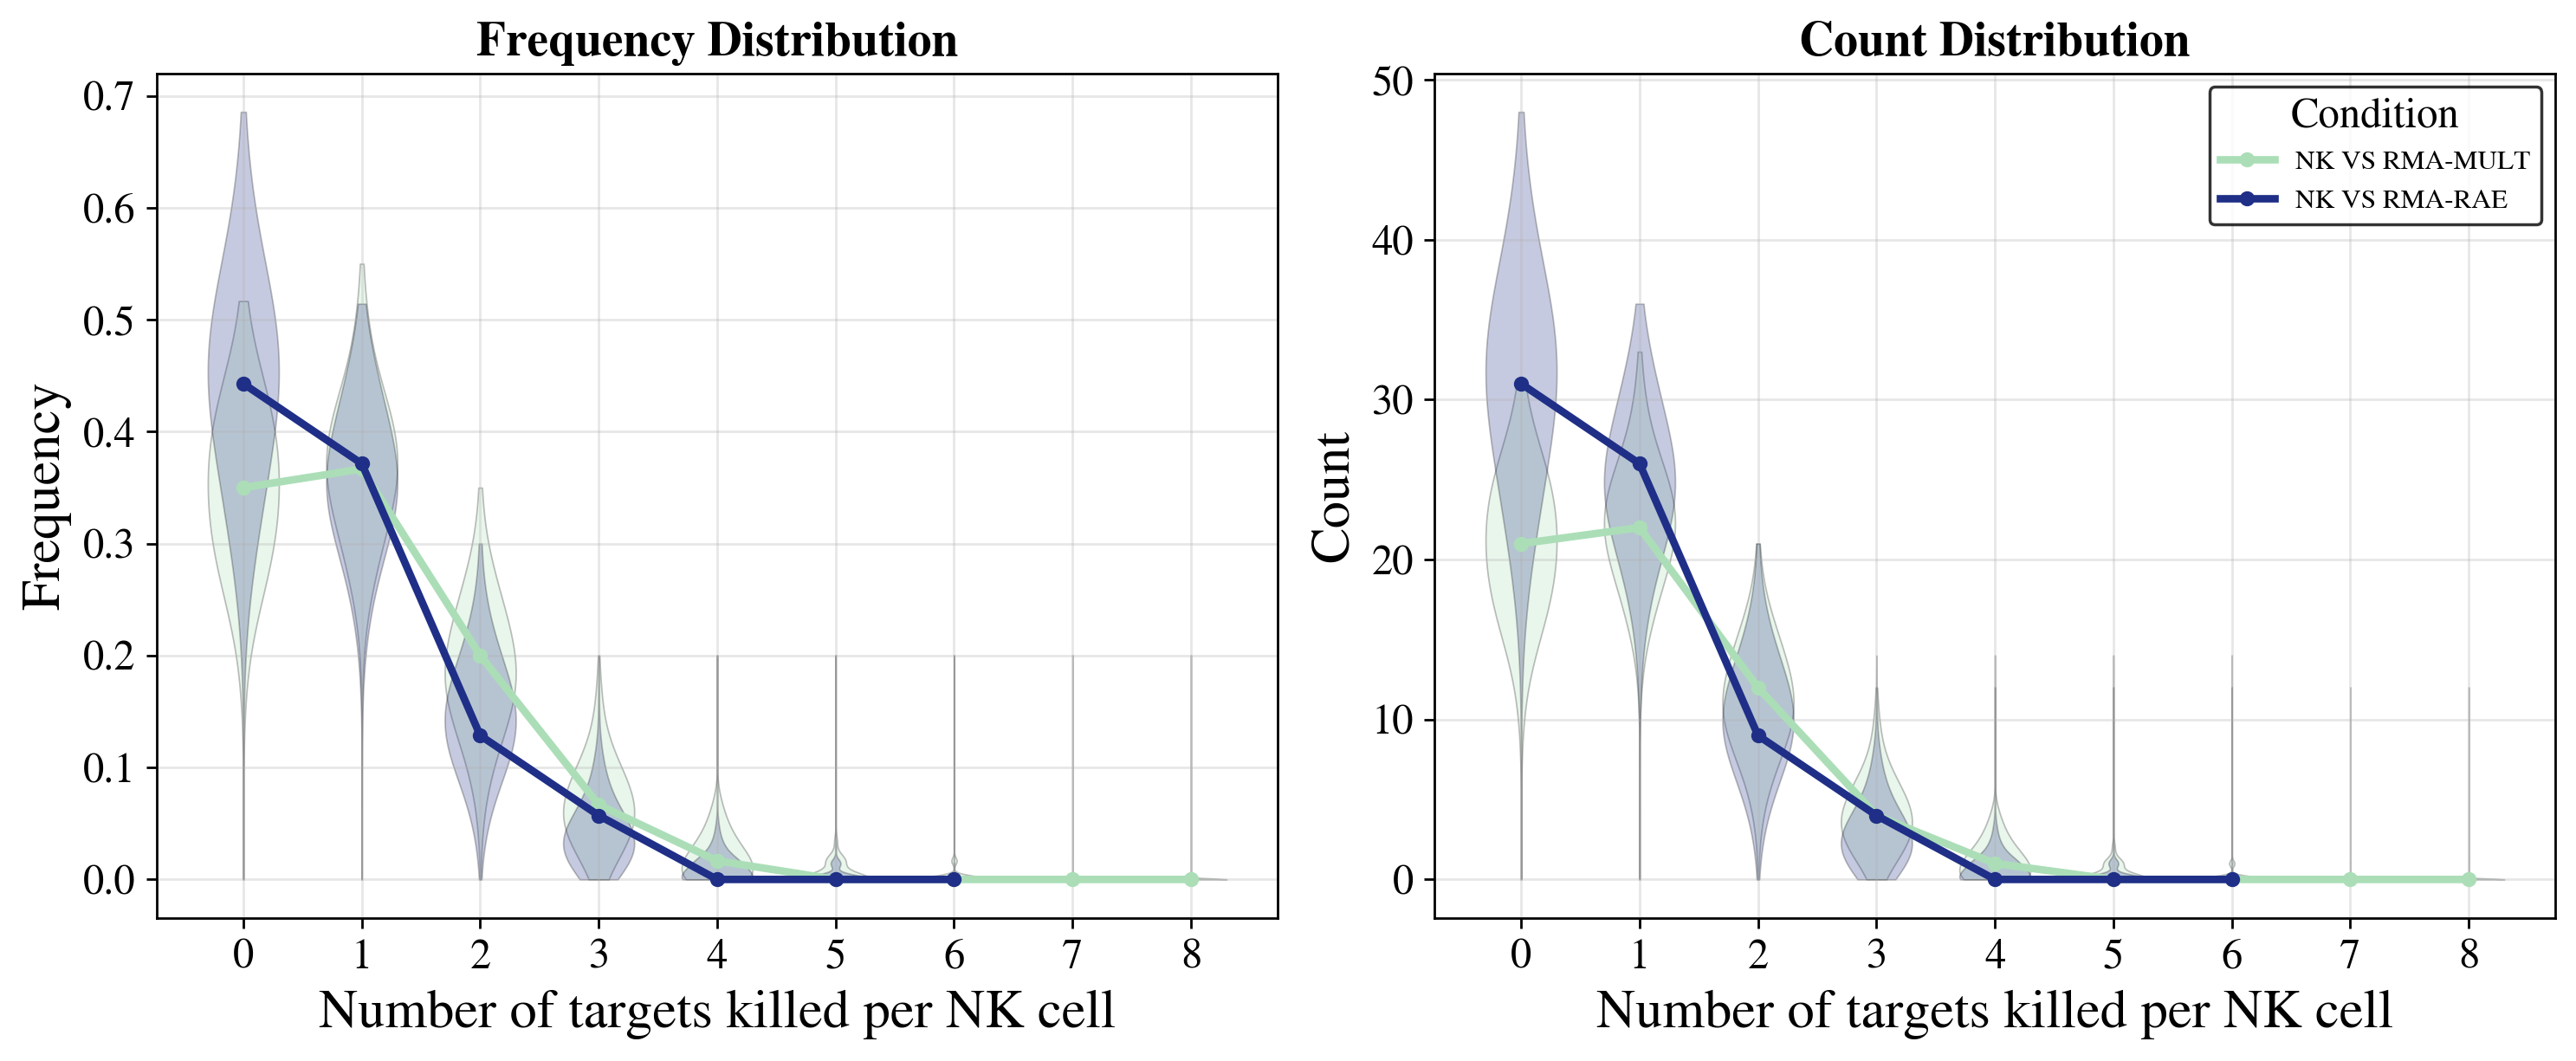

In [1]:
# --- Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator, MaxNLocator
from matplotlib.patches import Patch
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from scipy.stats import gaussian_kde
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib as mpl

# --- Plot style ---
plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "legend.fontsize": 12,
    "legend.title_fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000


# --- Data loading ---
def load_csv(file_path: str) -> pd.DataFrame | None:
    if not os.path.exists(file_path):
        print(f"Error: CSV File not found at path '{file_path}'")
        return None
    try:
        df = pd.read_csv(file_path)
        print("\nDataFrame Head:")
        display(df.head())
        return df
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return None


# --- Extract subsets ---
def extract_experimental_data(df):
    df_mult = df.query("experiment_condi == 'NK_VS_RMA-MULT'")
    df_rae = df.query("experiment_condi == 'NK_VS_RMA-RAE'")
    mult_array = df_mult['kill_No'].to_numpy(dtype=int)
    rae_array = df_rae['kill_No'].to_numpy(dtype=int)
    return {'NK VS RMA-MULT': mult_array, 'NK VS RMA-RAE': rae_array}


# --- Bayesian inference ---
def inference_one_i(kills_per_cell_array, draws=3000, tune=3000, chains=4, seed=None):
    with pm.Model() as model:
        eta = pm.Uniform("eta", lower=-3.0, upper=3.0)
        lam = pm.Deterministic("lam", 10.0 ** eta)
        pm.Poisson("K", mu=lam, observed=kills_per_cell_array)
        idata = pm.sample(
            draws=draws, tune=tune, chains=chains,
            target_accept=0.9, random_seed=seed, progressbar=True
        )
        try:
            idata = pm.compute_log_likelihood(idata, extend_inferencedata=True)
        except Exception:
            pass
    return idata


def inference_all_i(experiment, labels=None, draws=3000, tune=3000, chains=4, seed=None):
    if labels is None:
        labels = [f"cond_{i}" for i in range(len(experiment))]
    out = []
    for i in tqdm(range(len(experiment))):
        current_seed = seed + i if seed is not None else None
        idata = inference_one_i(
            kills_per_cell_array=experiment[i],
            draws=draws, tune=tune, chains=chains, seed=current_seed
        )
        out.append((labels[i], idata))
    return out


# --- KDE for violin density ---
def compute_kde(data_k, k, colour):
    if len(data_k) > 1:
        kde = gaussian_kde(data_k.astype(np.float32), bw_method=0.7)
        y_grid = np.linspace(0, max(data_k.max(), 0.2), 300)
        density = kde(y_grid)
        density = density / density.max() * 0.3
        return (k, y_grid, density, colour)
    return None


# --- Combined experimental + posterior plot ---
def plot_experimental_and_posterior_violin(idatas, experiments, colours=None, n_reps=200, seed=42):
    rng = np.random.default_rng(seed)
    if colours is None:
        cmap = get_cmap('YlGnBu')
        colours = cmap(np.linspace(0.3, 0.9, len(idatas)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=250, sharex=True)
    ax_freq, ax_count = axes

    for (label, idata), exp_data, colour in zip(idatas, experiments, colours):
        lam_samples = idata.posterior["lam"].stack(sample=("chain", "draw")).values.flatten()
        n_cells = len(exp_data)

        sim_freqs_per_rep = []
        for _ in tqdm(range(n_reps), desc=f"Sampling posterior predictions ({label})", leave=False):
            lam = rng.choice(lam_samples)
            sim_kills = rng.poisson(lam, size=n_cells)
            max_k = max(sim_kills.max(), exp_data.max())
            freq, _ = np.histogram(sim_kills, bins=np.arange(max_k + 2), density=True)
            sim_freqs_per_rep.append(freq)

        max_kill = max(exp_data.max(), max(len(f) for f in sim_freqs_per_rep) - 1)
        exp_counts = np.bincount(exp_data, minlength=max_kill + 1)
        exp_freqs = exp_counts / n_cells
        sim_pad_len = max_kill + 1
        sim_freqs_fixed = []
        for freq in sim_freqs_per_rep:
            if len(freq) < sim_pad_len:
                freq = np.pad(freq, (0, sim_pad_len - len(freq)), 'constant')
            sim_freqs_fixed.append(freq)
        all_sim_freqs = np.vstack(sim_freqs_fixed)

        kde_iter = (delayed(compute_kde)(all_sim_freqs[:, k], k, colour) for k in range(sim_pad_len))
        kde_results = list(tqdm(
            Parallel(n_jobs=-1, prefer="processes")(kde_iter),
            total=sim_pad_len,
            desc=f"KDE estimation ({label})",
            leave=False
        ))

        x = np.arange(len(exp_counts))
        ax_freq.plot(x, exp_freqs, color=colour, linewidth=2.5, label=f"{label}", marker='o', markersize=4)
        ax_count.plot(x, exp_counts, color=colour, linewidth=2.5, label=f"{label}", marker='o', markersize=4)

        for result in kde_results:
            if result is not None:
                k, y_grid, density, colour = result
                ax_freq.fill_betweenx(y_grid, k - density, k + density, color=colour, alpha=0.25, edgecolor='black', linewidth=0.5)
                ax_count.fill_betweenx(y_grid * n_cells, k - density, k + density, color=colour, alpha=0.25, edgecolor='black', linewidth=0.5)

    ax_freq.set_title("Frequency Distribution", fontweight='bold')
    ax_count.set_title("Count Distribution", fontweight='bold')
    ax_freq.set_ylabel("Frequency")
    ax_count.set_ylabel("Count")
    for ax in (ax_freq, ax_count):
        ax.set_xlabel("Number of targets killed per NK cell")
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.grid(True, alpha=0.3)
    ax_count.legend(title="Condition", frameon=True, edgecolor='black', loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.show()


# --- Run interactively in Jupyter ---
csv_path = "./organised_data.csv"
df = load_csv(csv_path)

if df is not None:
    experimental_dic = extract_experimental_data(df)
    experiments = [experimental_dic[k] for k in experimental_dic.keys()]
    conditions = list(experimental_dic.keys())
    cmap = get_cmap('YlGnBu')
    colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

    idatas = inference_all_i(
        experiment=experiments,
        labels=conditions,
        draws=1000,   # you can lower this for quick testing
        tune=1000,
        chains=4,
        seed=42,
    )

    plot_experimental_and_posterior_violin(
        idatas=idatas,
        experiments=experiments,
        colours=colors,
        n_reps=200,   # increase later for smoother violins
    )


DataFrame Head:


,experiment_condi,cell_id,kill_No,duration(hr)
0,NK_VS_RMA-MULT,1,0,12
1,NK_VS_RMA-MULT,2,0,12
2,NK_VS_RMA-MULT,3,0,12
3,NK_VS_RMA-MULT,4,0,12
4,NK_VS_RMA-MULT,5,0,12


/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_20086/2946770066.py:159: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu')
  0%|          | 0/2 [00:00<?, ?it/s]Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

 50%|█████     | 1/2 [00:00<00:00,  1.50it/s]Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

100%|██████████| 2/2 [00:01<00:00,  1.44it/s]



🔹 Generating posterior predictions for: NK VS RMA-MULT


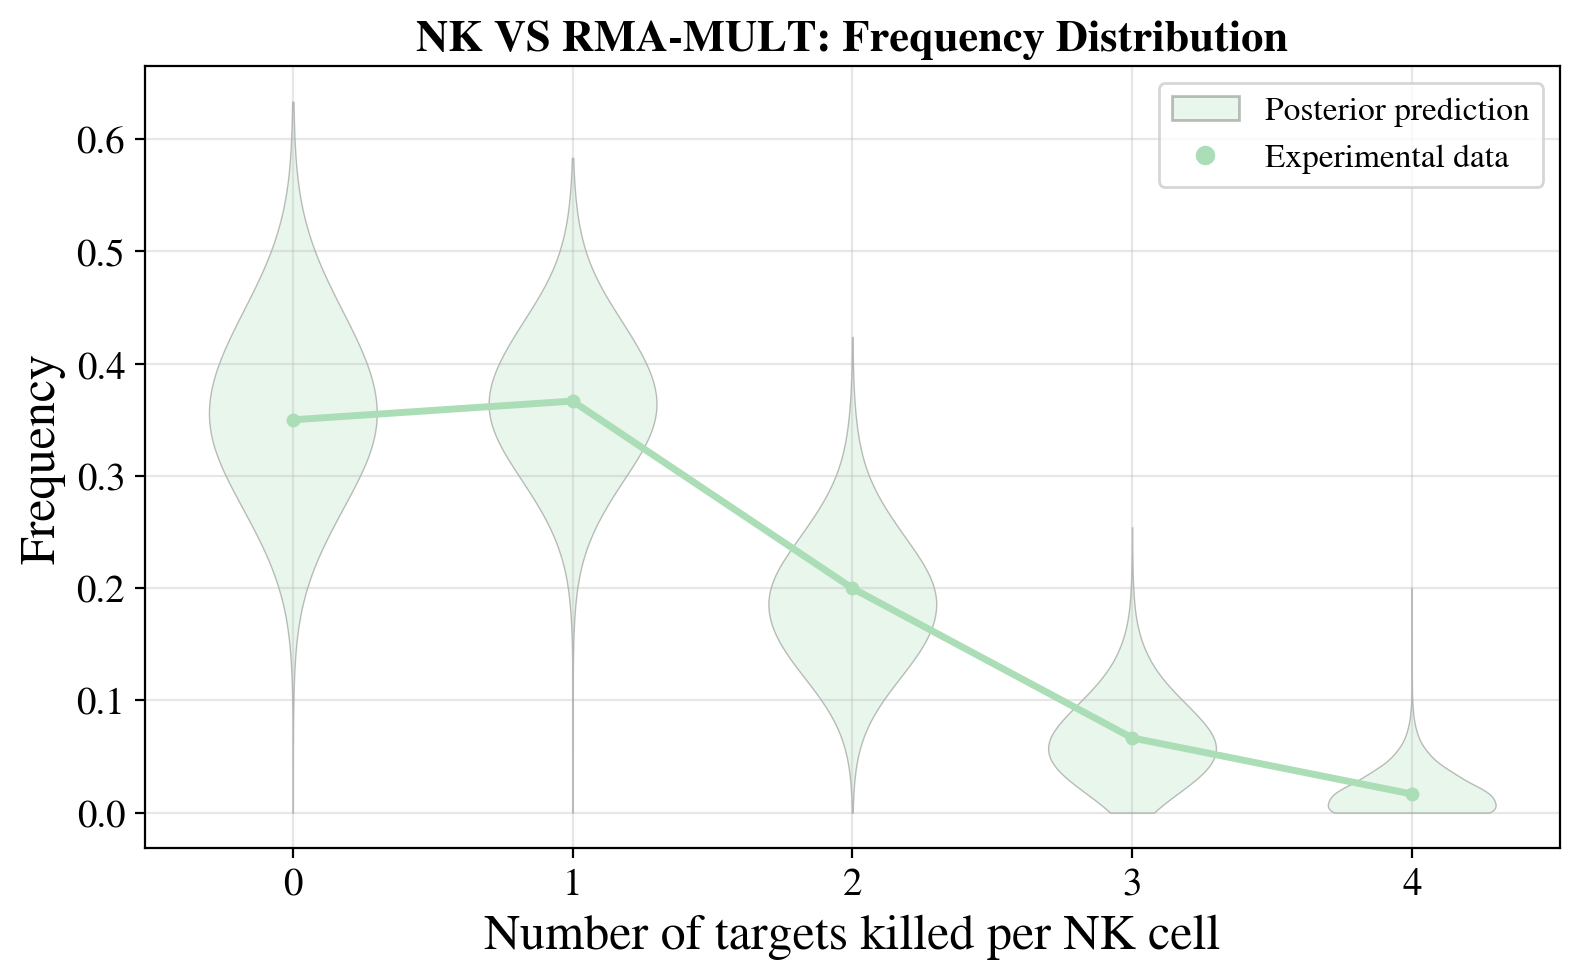


🔹 Generating posterior predictions for: NK VS RMA-RAE


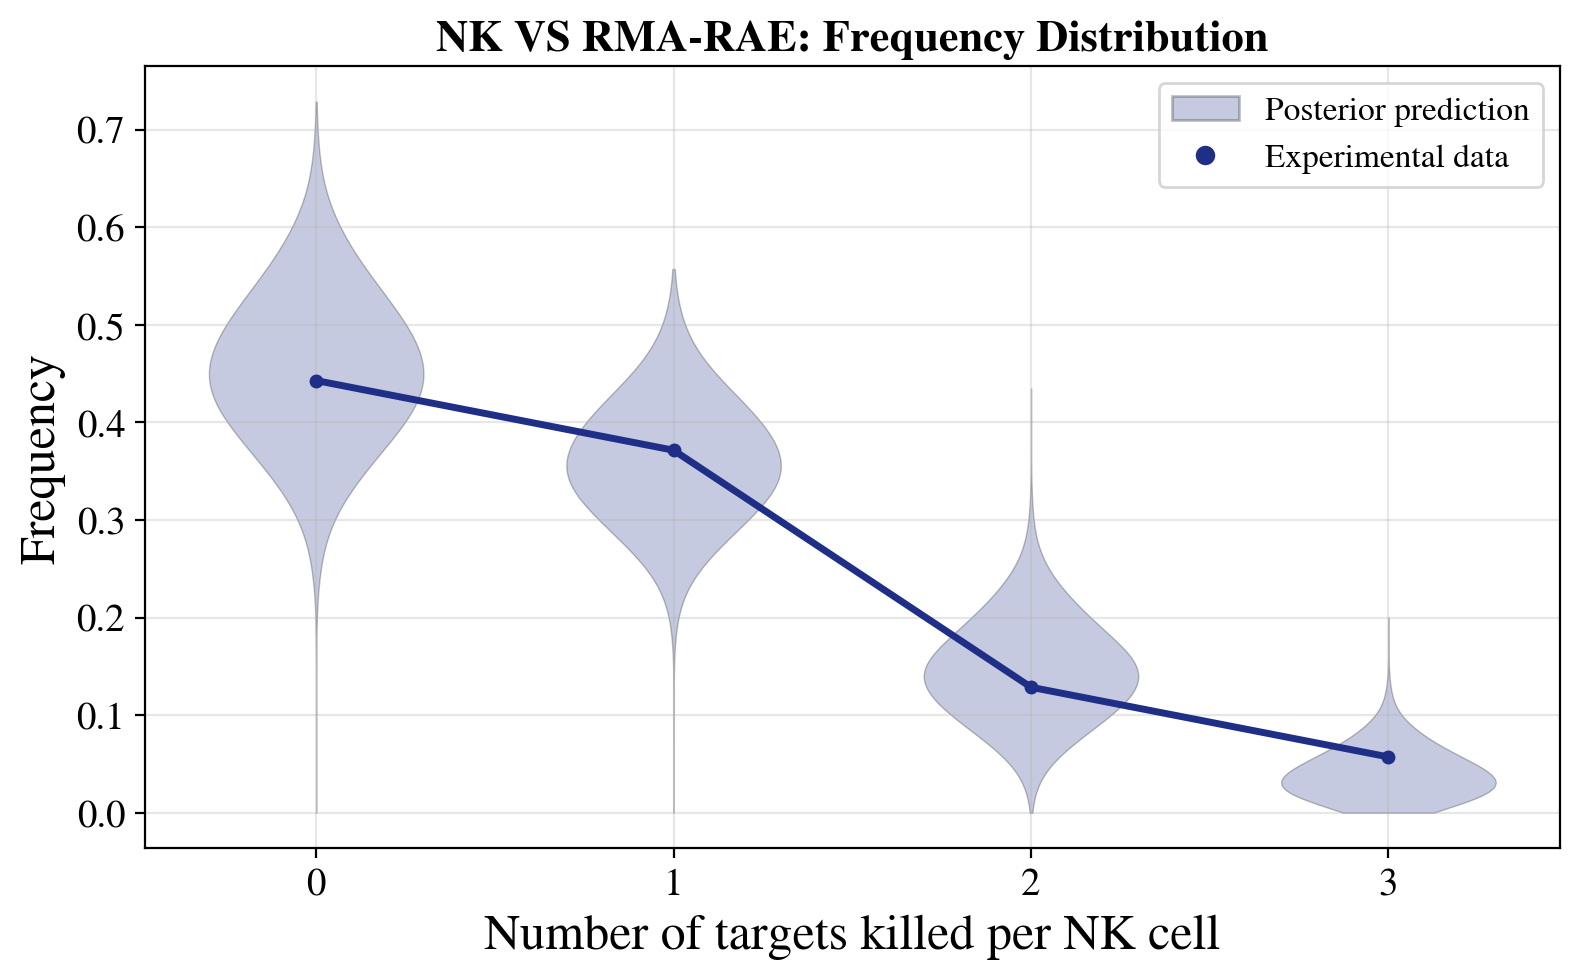

In [ ]:
# --- Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from scipy.stats import gaussian_kde
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib as mpl

# --- Plot style ---
plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "legend.fontsize": 12,
    "legend.title_fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000


# --- Load CSV ---
def load_csv(file_path: str) -> pd.DataFrame | None:
    if not os.path.exists(file_path):
        print(f"Error: CSV File not found at path '{file_path}'")
        return None
    try:
        df = pd.read_csv(file_path)
        print("\nDataFrame Head:")
        display(df.head())
        return df
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return None


# --- Extract subsets ---
def extract_experimental_data(df):
    df_mult = df.query("experiment_condi == 'NK_VS_RMA-MULT'")
    df_rae = df.query("experiment_condi == 'NK_VS_RMA-RAE'")
    mult_array = df_mult['kill_No'].to_numpy(dtype=int)
    rae_array = df_rae['kill_No'].to_numpy(dtype=int)
    return {'NK VS RMA-MULT': mult_array, 'NK VS RMA-RAE': rae_array}


# --- Inference ---
def inference_one_i(kills_per_cell_array, draws=2000, tune=2000, chains=4, seed=None):
    with pm.Model() as model:
        eta = pm.Uniform("eta", lower=-3.0, upper=3.0)
        lam = pm.Deterministic("lam", 10.0 ** eta)
        pm.Poisson("K", mu=lam, observed=kills_per_cell_array)
        idata = pm.sample(draws=draws, tune=tune, chains=chains,
                          target_accept=0.9, random_seed=seed, progressbar=True)
        try:
            idata = pm.compute_log_likelihood(idata, extend_inferencedata=True)
        except Exception:
            pass
    return idata


def inference_all_i(experiment, labels=None, draws=2000, tune=2000, chains=4, seed=None):
    if labels is None:
        labels = [f"cond_{i}" for i in range(len(experiment))]
    out = []
    for i in tqdm(range(len(experiment))):
        current_seed = seed + i if seed is not None else None
        idata = inference_one_i(
            kills_per_cell_array=experiment[i],
            draws=draws, tune=tune, chains=chains, seed=current_seed
        )
        out.append((labels[i], idata))
    return out


# --- KDE ---
def compute_kde(data_k, k, colour):
    if len(data_k) > 1:
        data_reflect = np.concatenate([data_k, -data_k])
        kde = gaussian_kde(data_reflect.astype(np.float32), bw_method=0.4)
        y_grid = np.linspace(0, max(data_k.max(), 0.2), 300)
        density = kde(y_grid)
        density = density / np.max(density) * 0.25
        return (k, y_grid, density, colour)
    return None


# --- Combined plot (one per condition) ---
def plot_posterior_violin_per_condition(idatas, experiments, colours=None, n_reps=200, seed=42):
    rng = np.random.default_rng(seed)
    if colours is None:
        cmap = get_cmap('YlGnBu')
        colours = cmap(np.linspace(0.3, 0.9, len(idatas)))

    for (label, idata), exp_data, colour in zip(idatas, experiments, colours):
        print(f"\n🔹 Generating posterior predictions for: {label}")
        lam_samples = idata.posterior["lam"].stack(sample=("chain", "draw")).values.flatten()
        n_cells = len(exp_data)
        max_exp_kill = int(exp_data.max())

        sim_freqs_per_rep = []
        for _ in tqdm(range(n_reps), desc=f"Sampling posterior predictions ({label})", leave=False):
            lam = rng.choice(lam_samples)
            sim_kills = rng.poisson(lam, size=n_cells)
            sim_kills = sim_kills[sim_kills <= max_exp_kill]  # cut above experimental max
            freq, _ = np.histogram(sim_kills, bins=np.arange(max_exp_kill + 2), density=True)
            sim_freqs_per_rep.append(freq)

        exp_counts = np.bincount(exp_data, minlength=max_exp_kill + 1)
        exp_freqs = exp_counts / n_cells
        sim_pad_len = max_exp_kill + 1
        all_sim_freqs = np.vstack(sim_freqs_per_rep)

        kde_iter = (delayed(compute_kde)(all_sim_freqs[:, k], k, colour) for k in range(sim_pad_len))
        kde_results = list(tqdm(
            Parallel(n_jobs=-1, prefer="processes")(kde_iter),
            total=sim_pad_len, desc=f"KDE estimation ({label})", leave=False
        ))

        fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
        x = np.arange(len(exp_counts))
        ax.plot(x, exp_freqs, color=colour, linewidth=2.5, label=f"{label}", marker='o', markersize=4)
        for result in kde_results:
            if result is not None:
                k, y_grid, density, colour = result
                ax.fill_betweenx(y_grid, k - density, k + density,
                                 color=colour, alpha=0.25, edgecolor='black', linewidth=0.5)

        ax.set_title(f"{label}: Frequency Distribution", fontweight='bold')
        ax.set_xlabel("Number of targets killed per NK cell")
        ax.set_ylabel("Frequency")
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.grid(True, alpha=0.3)
        legend_patches = [Patch(facecolor=colour, edgecolor='black',
                                label='Posterior prediction', alpha=0.25)]
        ax.legend(handles=legend_patches + [
            plt.Line2D([0], [0], marker='o', color='w', label='Experimental data',
                       markerfacecolor=colour, markersize=8)
        ], loc='upper right')
        plt.tight_layout()
        plt.show()


# --- Run interactively in Jupyter ---
csv_path = "./organised_data.csv"
df = load_csv(csv_path)

if df is not None:
    experimental_dic = extract_experimental_data(df)
    experiments = [experimental_dic[k] for k in experimental_dic.keys()]
    conditions = list(experimental_dic.keys())
    cmap = get_cmap('YlGnBu')
    colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

    idatas = inference_all_i(
        experiment=experiments,
        labels=conditions,
        draws=1000,   # reduce for faster testing
        tune=1000,
        chains=4,
        seed=42,
    )

    plot_posterior_violin_per_condition(
        idatas=idatas,
        experiments=experiments,
        colours=colors,
        n_reps=5000,
    )